# 深度学习框架实战

## 山东理工大学 数学与统计学院 周世祥
 
## Keras卷积神经网络识别手写体 

Convolutional Neural  Network简称CNN，是由计算机科学家Yann LeCun所提出，在计算机视觉等诸多领域都有贡献。

### CNN简介

多层感知器与卷积神经网络的主要差异是：卷积神经网络增加了卷积层1，池化层1，卷积层2，池化层2的处理来提取特征。

卷积运算的效果类似于滤波效果，即用于提取不同的特征，downsampling就是缩减采样。

卷积层的意义是将原本一个图像经过卷积运算产生多个图像，就好像将相片叠加起来。

卷积运算方式：
<img src="conv2d.jpg" width = 70% alt="卷积运算示意" />

卷积运算并不会改变图像大小，处理后的图形大小不变。

Max-Pool运算：

<img src="pooling.jpg" width = 50% alt="池化示意" />

缩减采样会缩小图像，有下列好处：

1. 减少需要处理的数据点，减少后续运算所需时间；
2. 让图像位置差异变小，位置的上下左右，位置不同会影响识别，减小图像让位置差异更小；
3. 参数的数量和计算量下降，避免过度拟合。

### 建立卷积神经网络的步骤

卷积神经网络因为必须先进行卷积与池化运算，所以必须保持图像的维数，所以reshape转换为60000项，每一项是28\*28\*1的图像，分别是28宽\*28高\*1单色。

<img src="CNN.jpg" width = 70% alt="卷积神经网络结构" />

**导入所需模块**



In [23]:
import tensorflow as tf
tf.__version__
#这个命令居然让cpu占到98%，搞不懂

'1.2.1'

In [24]:
import keras
keras.__version__

'2.0.2'

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
np.random.seed(10)

Using TensorFlow backend.


### 数据预处理

In [2]:
(x_Train, y_Train), (x_Test, y_Test) = mnist.load_data()

将features数字图像特征值转换为四维矩阵，以reshape转为60000乘以28乘以28再乘以1的4维矩阵。

In [3]:
x_Train4D=x_Train.reshape(x_Train.shape[0],28,28,1).astype('float32')
x_Test4D=x_Test.reshape(x_Test.shape[0],28,28,1).astype('float32')

In [4]:
x_Train4D_normalize = x_Train4D / 255
x_Test4D_normalize = x_Test4D / 255
#将特征值标准化可以提高模型预测的准确度，并且收敛更快。

In [5]:
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)
#将数字真实值label以One-Hot Encoding进行转换

建立模型


In [6]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
#导入模块


In [7]:
model = Sequential()
#仍然是线性堆叠模型

In [8]:
model.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(28,28,1), 
                 activation='relu'))
#一个完整的卷积运算包含一个卷积层与一个池化层
#此为卷积层1，输入图像大小是28*28，进行一次卷积运算会产生16个图像，卷积运算不改变图像大小。
#kernel_size=(5,5) 5*5大小的滤镜
# padding='same',此设置人卷积运算产生的卷积图像大小不变
#input_shape=(28,28,1)，第一，二维代表输入图像形状为28*28，第三维因为是单色灰度图像，所以最后的维数是1


In [9]:
model.add(MaxPooling2D(pool_size=(2, 2)))
#建立池化层
#执行一次缩减采样
#将16个28*28的图形缩小为16个14*14的图形


In [10]:
model.add(Conv2D(filters=36,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))
#建立卷基层2，执行第二次卷积运算，
#将原本的16个图像转换为36个图像，卷积运算不会改变图形大小，所以图像仍然是14*14


In [12]:
model.add(MaxPooling2D(pool_size=(2, 2)))
#建立池化层2，并且加入DropOut避免过度拟合


In [14]:
model.add(Dropout(0.25))
#每次训练迭代时会随机在神经网络中放弃25%的神经元避免过拟合

In [15]:
model.add(Flatten())
#建立平坦层，将前面池化层2下来的36个7*7的图形转换成一维向量，长度是36*7*7，即
#1764个float，正好对应1764个神经元

In [16]:
model.add(Dense(128, activation='relu'))
#建立隐藏层，共有128个神经元

In [17]:
model.add(Dropout(0.5))
#每次训练迭代时会随机在神经网络中放弃50%的神经元避免过拟合

In [18]:
model.add(Dense(10,activation='softmax'))
#加入输出层


In [19]:
print(model.summary())
#查看模型摘要

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 36)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 36)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 36)          0         
__________

### 进行训练

使用反向传播算法进行训练，在训练之前，先使用compile方法对训练模型进行设置。

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy'])
#loss='categorical_crossentropy'设置损失函数，交叉熵
#使用adam优化器可以让训练更快收敛
#设置评估模型的方式是准确率

In [22]:
train_history=model.fit(x=x_Train4D_normalize, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)
#verbose=2显示训练过程
#batch_size=300每一批次300项数据
#epochs=20执行20个训练周期
#validation_split=0.2，将80%作为训练数据，20%作为验证数据，48000作为训练数据
#12000作为验证数据，使用48000项训练数据进行训练，分为一批次300项，所以大约分为160批次


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
64s - loss: 0.8482 - acc: 0.7176 - val_loss: 0.1249 - val_acc: 0.9637
Epoch 2/20
61s - loss: 0.2350 - acc: 0.9284 - val_loss: 0.0818 - val_acc: 0.9759
Epoch 3/20
61s - loss: 0.1719 - acc: 0.9478 - val_loss: 0.0647 - val_acc: 0.9808
Epoch 4/20
63s - loss: 0.1444 - acc: 0.9562 - val_loss: 0.0563 - val_acc: 0.9841
Epoch 5/20
63s - loss: 0.1272 - acc: 0.9612 - val_loss: 0.0520 - val_acc: 0.9843
Epoch 6/20
63s - loss: 0.1132 - acc: 0.9653 - val_loss: 0.0451 - val_acc: 0.9875
Epoch 7/20
64s - loss: 0.1039 - acc: 0.9684 - val_loss: 0.0418 - val_acc: 0.9877
Epoch 8/20
65s - loss: 0.0969 - acc: 0.9709 - val_loss: 0.0390 - val_acc: 0.9885
Epoch 9/20
65s - loss: 0.0874 - acc: 0.9737 - val_loss: 0.0362 - val_acc: 0.9900
Epoch 10/20
66s - loss: 0.0838 - acc: 0.9753 - val_loss: 0.0358 - val_acc: 0.9898
Epoch 11/20
67s - loss: 0.0808 - acc: 0.9754 - val_loss: 0.0337 - val_acc: 0.9905
Epoch 12/20
67s - loss: 0.0743 - acc: 0.9772 - val_loss: 

In [25]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
#画出准确率执行结果
#acc是训练的准确率，val_acc是验证的准确率

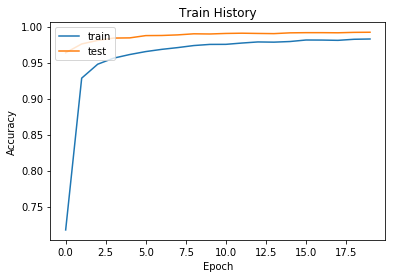

In [26]:
show_train_history('acc','val_acc')

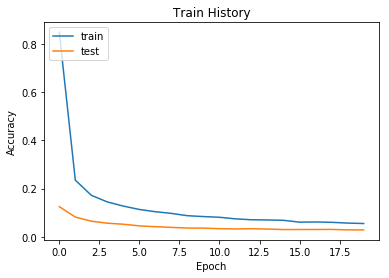

In [27]:
show_train_history('loss','val_loss')
#画出误差误差执行结果


### 评价模型准确率
使用测试数据集来评估模型准确率。使用卷积神经网络来识别MNIST数据集，分类精度接近0.99.


In [29]:
scores = model.evaluate(x_Test4D_normalize , y_TestOneHot)
scores[1]

 9920/10000 [============================>.] - ETA: 0s

0.9929

### 进行预测

In [30]:
prediction=model.predict_classes(x_Test4D_normalize)
#x_Test4D_normalize指已标注化了的测试数据

 9952/10000 [============================>.] - ETA: 0s

In [31]:
prediction[:10]
#查看预测结果的前十项

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [32]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')

        ax.set_title("label=" +str(labels[idx])+
                     ",predict="+str(prediction[idx])
                     ,fontsize=10) 
        
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()
#查看预测结果

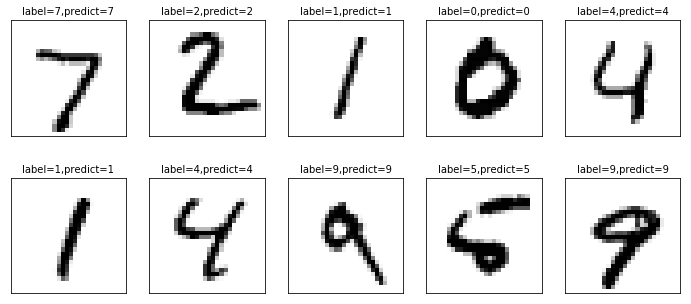

In [33]:
plot_images_labels_prediction(x_Test,y_Test,prediction,idx=0)


confusion matrix
 显示混淆矩阵

In [34]:
import pandas as pd
pd.crosstab(y_Test,prediction,
            rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,974,0,1,0,0,0,3,1,1,0
1,0,1132,2,0,0,0,1,0,0,0
2,2,0,1025,0,1,0,0,3,1,0
3,0,0,1,1006,0,2,0,1,0,0
4,0,0,0,0,980,0,1,0,0,1
5,0,0,0,4,0,885,1,0,0,2
6,4,4,0,0,2,3,944,0,1,0
7,0,2,3,2,0,0,0,1019,1,1
8,0,0,1,2,0,1,0,0,967,3


对角线上是预测正确的数字，真实值是1被正确预测为1的项数有1132项，最高，即最不容易混淆，真实值为5被正确预测为5的有885项，最低。真实值为9但是被预测为9时最高，也是最容易混淆。



In [35]:
df = pd.DataFrame({'label':y_Test, 'predict':prediction})
df[(df.label==5)&(df.predict==3)]

,label,predict
674,5,3
2035,5,3
2597,5,3
5937,5,3


## 参考文献

1. TensorFlow+Keras深度学习人工智能实践应用，林大贵，清华大学出版社，2018.